In [1]:
import psycopg2
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import re
import datetime
import random
import nltk
import numpy as np

In [5]:
ADMISSIONS_df = pd.read_csv("ADMISSIONS.csv")
DIAGNOSES_ICD_df = pd.read_csv("DIAGNOSES_ICD.csv")

In [3]:
ADMISSIONS_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


### Organize ethnic groups into fewer groups 

In [4]:
ethnicity_df = ADMISSIONS_df["ETHNICITY"].copy()
ethnicity_df.replace(to_replace=' - [A-Z]*',value='',regex=True, inplace=True)
ethnicity_df.replace(to_replace='/[A-Z]*',value='',regex=True, inplace=True)
ethnicity_df.replace(to_replace=' [A-Z]*',value='',regex=True,inplace=True)
ethnicity_df.replace(to_replace=['UNKNOWN','UNABLE','PATIENT','MULTI','AMERICAN','PORTUGUESE','MIDDLE','NATIVE','HISPANIC(OTHER)','CARIBBEAN','SOUTH'],value='OTHER',inplace=True)
ethnicity_df.value_counts()

WHITE       41325
OTHER        7744
BLACK        5785
HISPANIC     2115
ASIAN        2007
Name: ETHNICITY, dtype: int64

### Clean up Diagnosis

In [6]:
diagnosis_df = ADMISSIONS_df["DIAGNOSIS"].copy()

In [7]:
diagnosis_df = diagnosis_df.to_frame()

In [8]:
diagnosis_df["D1"]='k'
diagnosis_df["D2"]='k'
diagnosis_df["D3"]='k'
diagnosis_df["D4"]='k'
diagnosis_df["D5"]='k'
diagnosis_df["D6"]='k'

In [9]:
for idx,row in enumerate(diagnosis_df.itertuples(),1):
    if type(row.DIAGNOSIS) == str:
        diag_list_semi = row.DIAGNOSIS.split(';')
        diag_list_back_slash = row.DIAGNOSIS.split('\\')
        if len(diag_list_back_slash) >= len(diag_list_semi):
                if len(diag_list_back_slash) == 1:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D6"]=diag_list_back_slash[0]                   
                elif len(diag_list_back_slash) == 2:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D4"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_back_slash)
                elif len(diag_list_back_slash) == 3:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[2]
                    diagnosis_df.at[row.Index,"D4"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_back_slash)
                elif len(diag_list_back_slash) == 4:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_back_slash[3]
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_back_slash)                   
                elif len(diag_list_back_slash) == 5:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_back_slash[3]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_back_slash[4]
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_back_slash)
                elif len(diag_list_back_slash) == 6:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_back_slash[3]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_back_slash[4]
                    diagnosis_df.at[row.Index,"D6"]=diag_list_back_slash[5]           
        else:
                if len(diag_list_semi) == 1:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D6"]=diag_list_semi[0]                   
                elif len(diag_list_semi) == 2:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D4"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_semi)
                elif len(diag_list_semi) == 3:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[2]
                    diagnosis_df.at[row.Index,"D4"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_semi)
                elif len(diag_list_semi) == 4:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_semi[3]
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_semi)
                elif len(diag_list_semi) == 5:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_semi[3]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_semi[4]
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_semi)
                elif len(diag_list_semi) == 6:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_semi[3]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_semi[4]
                    diagnosis_df.at[row.Index,"D6"]=diag_list_semi[5]
    else:
        diagnosis_df.at[row.Index,"DIAGNOSIS"] = 'NONE'
        diagnosis_df.at[row.Index,"D1"]='NONE'
        diagnosis_df.at[row.Index,"D2"]='NONE'
        diagnosis_df.at[row.Index,"D3"]='NONE'
        diagnosis_df.at[row.Index,"D4"]='NONE'
        diagnosis_df.at[row.Index,"D5"]='NONE'
        diagnosis_df.at[row.Index,"D6"]='NONE'

In [10]:
diagnosis_df.head()

,DIAGNOSIS,D1,D2,D3,D4,D5,D6
0,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE
1,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,CORONARY ARTERY DISEASE,CORONARY ARTERY BYPASS GRAFT/SDA,CORONARY ARTERY BYPASS GRAFT/SDA,CORONARY ARTERY DISEASE,CORONARY ARTERY BYPASS GRAFT/SDA,CORONARY ARTERY DISEASE
2,BRAIN MASS,BRAIN MASS,BRAIN MASS,BRAIN MASS,BRAIN MASS,BRAIN MASS,BRAIN MASS
3,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION
4,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME


## Get Patient vitals

In [12]:
df_temperatures = pd.read_csv("./temps/temperatures_trunc.csv",header=None)
df_temperatures.rename(columns={0:"SUBJECT_ID",1:"HADM_ID",2:"temperature_F"},inplace=True)
df_temperatures.drop_duplicates(subset=["SUBJECT_ID","HADM_ID"],inplace=True)
df_temperatures["temperature_F"] = df_temperatures["temperature_F"].round(2)

In [13]:
df_temperatures.head()

,SUBJECT_ID,HADM_ID,temperature_F
0,36,165660,97.3
1,34,144319,97.0
2,23,124321,98.4
31,85,112077,98.2
49,107,182383,97.6


In [14]:
df_heart_rate = pd.read_csv("./heart_rates/heart_rates_trunc.csv",header=None)
df_heart_rate.rename(columns={0:"SUBJECT_ID",1:"HADM_ID",2:"heart_rate_bps"},inplace=True)
df_heart_rate.drop_duplicates(subset=["SUBJECT_ID","HADM_ID"],inplace=True)
df_heart_rate.head()

,SUBJECT_ID,HADM_ID,heart_rate_bps
0,36,165660,86.0
4,34,144319,44.0
6,23,124321,85.0
141,85,112077,100.0
213,107,182383,73.0


In [25]:
# information used to create a database connection
sqluser = 'walter'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(host="localhost",dbname=dbname, user=sqluser, password="walters")


# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

In [26]:
query = query_schema + """
WITH co AS
(
SELECT adm.subject_id, adm.hadm_id
, adm.admittime - pat.dob AS age
FROM admissions adm
INNER JOIN patients pat
  ON adm.subject_id = pat.subject_id
)
SELECT
  co.subject_id, co.hadm_id, co.age
  , EXTRACT('year' FROM co.age) as age_extract_year 
  , EXTRACT('year' FROM co.age) 
    + EXTRACT('months' FROM co.age) / 12.0
    + EXTRACT('days' FROM co.age) / 365.242
    + EXTRACT('hours' FROM co.age) / 24.0 / 364.242
    as age_extract_precise
  , EXTRACT('epoch' from co.age) / 60.0 / 60.0 / 24.0 / 365.242 as age_extract_epoch
FROM co
"""
df_ages = pd.read_sql_query(query, con)


In [27]:
df_ages.drop(columns=["age","age_extract_year","age_extract_epoch"],inplace=True)
df_ages.rename(columns={"subject_id":"SUBJECT_ID","hadm_id":"HADM_ID"},inplace=True)

In [28]:
df_ages.head()

,SUBJECT_ID,HADM_ID,age_extract_precise
0,22,165315,64.928188
1,23,152223,71.131722
2,23,124321,75.256388
3,24,161859,39.017059
4,25,129635,58.950185


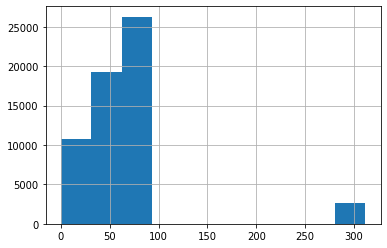

In [29]:
df_ages["age_extract_precise"].hist();

In [22]:
#use this line later to drop ages
#df_ages = df_ages[df_ages.age_extract_precise < 300.0]

### ADD AGES, TEMPERATURE, AND HEART RATE TO ADMISSIONS TABLE

In [31]:
admissions_copy = ADMISSIONS_df.copy()
admissions_copy.shape

(58976, 19)

In [32]:
admissions_copy = pd.merge(admissions_copy,df_ages,how='left',on=["SUBJECT_ID","HADM_ID"])
admissions_copy = pd.merge(admissions_copy,df_heart_rate,how='left',on=["SUBJECT_ID","HADM_ID"])
admissions_copy = pd.merge(admissions_copy,df_temperatures,how='left',on=["SUBJECT_ID","HADM_ID"])

In [33]:
admissions_copy.shape

(58976, 22)

In [34]:
admissions_copy["ETHNICITY"] = ethnicity_df

## ADD DIAGNOSES

In [35]:
admission_copy = pd.concat([admissions_copy,diagnosis_df[["D1","D2","D3","D4","D5","D6"]]],axis=1)

In [36]:
from sklearn.preprocessing import LabelBinarizer

In [37]:
#admission type
lb_style = LabelBinarizer()
lb_adm_type = lb_style.fit_transform(ADMISSIONS_df["ADMISSION_TYPE"])
adm_type = pd.DataFrame(lb_adm_type, columns=lb_style.classes_)
#admission location
lb_style = LabelBinarizer()
lb_adm_loc = lb_style.fit_transform(ADMISSIONS_df["ADMISSION_LOCATION"])
adm_loc = pd.DataFrame(lb_adm_loc, columns=lb_style.classes_)
#ethnicity
lb_style = LabelBinarizer()
lb_race = lb_style.fit_transform(ethnicity_df)
race = pd.DataFrame(lb_race, columns=lb_style.classes_)
#diagnosis
lb_style = LabelBinarizer()
lb_d1 = lb_style.fit_transform(diagnosis_df["D1"])
d1 =  pd.DataFrame(lb_d1, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d2 = lb_style.fit_transform(diagnosis_df["D2"])
#d2 =  pd.DataFrame(lb_d2, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d3 = lb_style.fit_transform(diagnosis_df["D3"])
#d3 =  pd.DataFrame(lb_d3, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d4 = lb_style.fit_transform(diagnosis_df["D4"])
#d4 =  pd.DataFrame(lb_d4, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d5 = lb_style.fit_transform(diagnosis_df["D5"])
#d5 =  pd.DataFrame(lb_d5, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d6 = lb_style.fit_transform(diagnosis_df["D6"])
#d6 =  pd.DataFrame(lb_d6, columns=lb_style.classes_)

## Calculate length of stay

In [38]:
admissions_copy.insert(5,"LOS",0)

In [39]:
admissions_copy["ADMITTIME"] = pd.to_datetime(admissions_copy["ADMITTIME"])
admissions_copy["DISCHTIME"] = pd.to_datetime(admissions_copy["DISCHTIME"])
admissions_copy["LOS"] = admissions_copy["DISCHTIME"] - admissions_copy["ADMITTIME"]
admissions_copy["LOS"]=admissions_copy["LOS"].dt.total_seconds()/datetime.timedelta(days=1).total_seconds()

In [40]:
admissions_copy.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LOS,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,age_extract_precise,heart_rate_bps,temperature_F
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,...,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,64.928188,116.0,98.5
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,...,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,71.131722,94.0,98.1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,...,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,75.256388,85.0,98.4
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,...,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,39.017059,NaN,97.6
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,58.950185,70.0,97.0


## Add preliminary diagnoses

In [41]:
cdiff_pos_diagnosis=pd.read_csv("./data/cdiff_pos_trunc.csv",header=None)
cdiff_pos_diagnosis_list = cdiff_pos_diagnosis[0].tolist()
cdiff_pos_diagnosis_df = d1[cdiff_pos_diagnosis_list]
cdiff_pos_diagnosis_df.head()

,SEPSIS,PNEUMONIA,FEVER,CONGESTIVE HEART FAILURE,HYPOTENSION,ABDOMINAL PAIN,ALTERED MENTAL STATUS,COLITIS,PANCREATITIS,UPPER GI BLEED,...,HYPERKALEMIA,BOWEL OBSTRUCTION,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
admissions_diagnosis_df = pd.concat([admissions_copy[["SUBJECT_ID","HADM_ID","LOS"]],adm_type,adm_loc,race,admissions_copy[["age_extract_precise","heart_rate_bps","temperature_F"]],cdiff_pos_diagnosis_df],axis=1)

## REMOVE NEWBORNS

In [51]:
admissions_diagnosis_newborn_df = admissions_diagnosis_df[admissions_diagnosis_df.NEWBORN != 1]

## FIX AGES

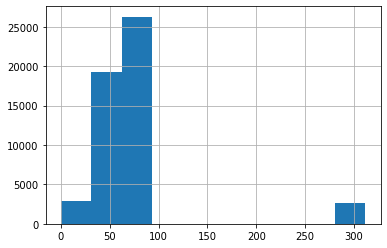

In [52]:
admissions_diagnosis_newborn_df["age_extract_precise"].hist();

In [53]:
#use this to drop ages corresponding to organ donors
admissions_diagnosis_newborn_df = admissions_diagnosis_newborn_df[admissions_diagnosis_newborn_df.age_extract_precise < 300.0]

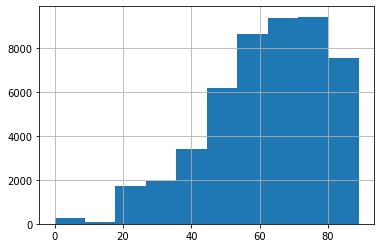

In [54]:
admissions_diagnosis_newborn_df["age_extract_precise"].hist();

In [65]:
for i in admissions_diagnosis_newborn_df["age_extract_precise"]:
    if np.isnan(i):
        print(i)
    elif i is None:
        print(i)

In [68]:
admissions_diagnosis_newborn_df.tail()

,SUBJECT_ID,HADM_ID,LOS,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,HYPERKALEMIA,BOWEL OBSTRUCTION,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA
58971,98800,191113,2.742361,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
58972,98802,101071,0.548611,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
58973,98805,122631,8.203472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58974,98813,170407,41.445833,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
58975,98813,190264,1.607639,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
admissions_diagnosis_newborn_df.reset_index(drop=True,inplace=True)

In [70]:
admissions_diagnosis_newborn_df.tail()

,SUBJECT_ID,HADM_ID,LOS,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,HYPERKALEMIA,BOWEL OBSTRUCTION,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA
48492,98800,191113,2.742361,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
48493,98802,101071,0.548611,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
48494,98805,122631,8.203472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48495,98813,170407,41.445833,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
48496,98813,190264,1.607639,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
df_temp_corrected = admissions_diagnosis_newborn_df["temperature_F"].fillna(98.6)

In [72]:
df_temp_corrected = df_temp_corrected.to_frame()

In [73]:
df_heart_rate_corrected = admissions_diagnosis_newborn_df["heart_rate_bps"].fillna(84.0)
df_heart_rate_corrected = df_heart_rate_corrected.to_frame()

In [75]:
admissions_diagnosis_newborn_df.tail()

,SUBJECT_ID,HADM_ID,LOS,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps
48492,98800,191113,2.742361,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,99.1,123.0
48493,98802,101071,0.548611,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,97.8,86.0
48494,98805,122631,8.203472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,99.0,120.0
48495,98813,170407,41.445833,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,98.6,84.0
48496,98813,190264,1.607639,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,98.2,113.0


### rename age_extract_precise and get rid of old temperature and heart rate

In [76]:
admissions_diagnosis_newborn_df.rename(columns={"age_extract_precise":"ages"},inplace=True)

In [78]:
admissions_diagnosis_newborn_df.drop(columns=["temperature_F","heart_rate_bps"],inplace=True)

In [79]:
admissions_diagnosis_newborn_df = pd.concat([admissions_diagnosis_newborn_df,df_temp_corrected,df_heart_rate_corrected],axis=1)

In [80]:
admissions_diagnosis_newborn_df.tail()

,SUBJECT_ID,HADM_ID,LOS,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps
48492,98800,191113,2.742361,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,99.1,123.0
48493,98802,101071,0.548611,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,97.8,86.0
48494,98805,122631,8.203472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,99.0,120.0
48495,98813,170407,41.445833,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,98.6,84.0
48496,98813,190264,1.607639,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,98.2,113.0


### Scale LOS, Ages, Temp, and Heart Rate

In [83]:
df_heart_rate = admissions_diagnosis_newborn_df["heart_rate_bps"].to_frame()

In [85]:
df_heart_rate.median()

heart_rate_bps    84.0
dtype: float64

In [96]:
df_heart_rate_scaled = (df_heart_rate - 84.0)/18.574

In [99]:
df_temperature = admissions_diagnosis_newborn_df["temperature_F"].to_frame()

In [100]:
df_temperature.median()

temperature_F    98.4
dtype: float64

In [101]:
df_temperature.std()

temperature_F    3.37459
dtype: float64

In [102]:
df_temperature_scaled = (df_temperature - 98.4)/3.3745

In [103]:
df_ages = admissions_diagnosis_newborn_df["ages"].to_frame()

In [104]:
df_ages.median()

ages    64.243139
dtype: float64

In [105]:
df_ages.std()

ages    17.133744
dtype: float64

In [106]:
df_ages_scaled = (df_ages - 64.243)/17.1337

In [107]:
df_los = admissions_diagnosis_newborn_df["LOS"].to_frame()

In [108]:
df_los.median()

LOS    6.90625
dtype: float64

In [109]:
df_los.std()

LOS    11.046324
dtype: float64

In [110]:
df_los_scaled = (df_los - 6.906)/11.04

In [111]:
admissions_scaled_features = admissions_diagnosis_newborn_df.copy()

In [112]:
admissions_scaled_features.drop(columns=["temperature_F","heart_rate_bps","ages","LOS"],inplace=True)

In [113]:
admissions_scaled_features = pd.concat([admissions_scaled_features,df_temperature_scaled,df_heart_rate_scaled,df_ages_scaled,df_los_scaled],axis=1)

In [114]:
admissions_scaled_features.tail()

,SUBJECT_ID,HADM_ID,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,HMO REFERRAL/SICK,...,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps,ages,LOS
48492,98800,191113,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.207438,2.099709,-2.617211,-0.377141
48493,98802,101071,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,-0.177804,0.107677,1.121229,-0.575850
48494,98805,122631,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.177804,1.938193,-1.267181,0.117525
48495,98813,170407,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.059268,0.000000,-0.202807,3.128608
48496,98813,190264,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,-0.059268,1.561322,-0.030540,-0.479924


In [115]:
ADMISSIONS_CDiff_pos_df = admissions_scaled_features.head(1).copy()
ADMISSIONS_CDiff_pos_df.drop([0],inplace=True)
ADMISSIONS_CDiff_neg_df = ADMISSIONS_CDiff_pos_df.copy()

for row in DIAGNOSES_ICD_df.itertuples():
    #C. Diff. has ICD9 Code 00845
    if row.ICD9_CODE == '00845':
        #print(row.SUBJECT_ID,row.HADM_ID,row.ICD9_CODE)
        subject_id = row.SUBJECT_ID
        hadm_id = row.HADM_ID
        ADMISSIONS_CDiff_pos_df = ADMISSIONS_CDiff_pos_df.append(admissions_scaled_features.loc[(admissions_scaled_features['SUBJECT_ID'] == subject_id) & (admissions_scaled_features['HADM_ID'] == hadm_id)])
        

In [116]:
ADMISSIONS_CDiff_pos_df.head()

,SUBJECT_ID,HADM_ID,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,HMO REFERRAL/SICK,...,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps,ages,LOS
181,21,111970,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,-0.237072,-0.323032,1.376425,0.119097
381,195,118936,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.503778,0.430710,0.588919,1.532958
427,243,129066,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.414876,-0.215355,-1.254031,0.207916
442,256,153771,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.059268,0.000000,0.918148,-0.032561
311,395,137967,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.325974,0.753742,0.576515,0.532619


In [117]:
ADMISSIONS_CDiff_neg_df = pd.concat([admissions_scaled_features,ADMISSIONS_CDiff_pos_df]).drop_duplicates(keep=False)

In [118]:
ADMISSIONS_CDiff_neg_df.shape

(47169, 73)

In [119]:
ADMISSIONS_CDiff_pos_df.shape

(1328, 73)

In [120]:
ADMISSIONS_CDiff_pos_df["target"]=1
ADMISSIONS_CDiff_neg_df["target"]=0

In [121]:
ADMISSIONS_CDiff_preprocess = pd.concat([ADMISSIONS_CDiff_pos_df,ADMISSIONS_CDiff_neg_df],ignore_index=True)

In [122]:
cdiff_pos_preprocess = ADMISSIONS_CDiff_preprocess.loc[ADMISSIONS_CDiff_preprocess['target'] == 1]
cdiff_neg_preprocess = ADMISSIONS_CDiff_preprocess.loc[ADMISSIONS_CDiff_preprocess['target'] == 0]

# EDA

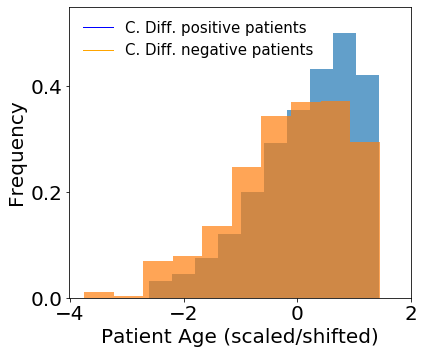

In [129]:
ax = plt.gca()
cdiff_pos_preprocess["ages"].hist(alpha=0.7, ax=ax, density=True,grid=False);
cdiff_neg_preprocess["ages"].hist(alpha=0.7, ax=ax, density=True,grid=False);
#create symbols for legend
cdiff_pos = mlines.Line2D([], [], c='b', lw=1.0, label = 'C. Diff. positive patients');
cdiff_neg = mlines.Line2D([], [], c='orange', lw=1.0, label='C. Diff. negative patients')
plt.legend(handles=[cdiff_pos,cdiff_neg],frameon=False,fontsize=15);
plt.xticks([-4,-2,0,2],fontsize=20);
plt.ylim(0.0,0.55);
plt.yticks([0.0,0.2,0.4],fontsize=20);
plt.xlabel('Patient Age (scaled/shifted)',fontsize=20);
plt.ylabel('Frequency',fontsize=20);
plt.rcParams["figure.figsize"] = [6.0,5.020];
plt.tight_layout();
plt.savefig("./week_4/age_comparison.jpg",dpi=300)

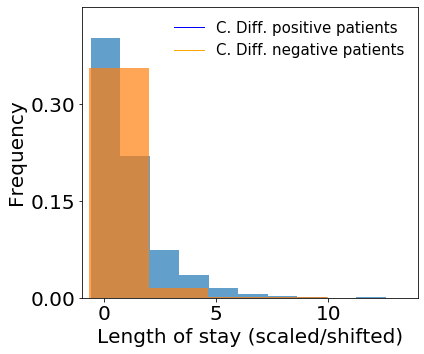

In [133]:
ax = plt.gca()
cdiff_pos_preprocess["LOS"].hist(density=True,alpha=0.7, ax=ax,grid=False);
cdiff_neg_preprocess["LOS"].hist(density=True,alpha=0.7, ax=ax,grid=False);
plt.xlim(-1,14);
#create symbols for legend
cdiff_pos = mlines.Line2D([], [], c='b', lw=1.0, label = 'C. Diff. positive patients');
cdiff_neg = mlines.Line2D([], [], c='orange', lw=1.0, label='C. Diff. negative patients')
plt.legend(handles=[cdiff_pos,cdiff_neg],frameon=False,fontsize=15);
plt.xticks([0,5,10],fontsize=20);
plt.ylim(0.0,0.45);
plt.yticks([0.0,0.15,0.3],fontsize=20);
plt.xlabel('Length of stay (scaled/shifted)',fontsize=20);
plt.ylabel('Frequency',fontsize=20)
plt.rcParams["figure.figsize"] = [6.0,5.020];
plt.tight_layout();
plt.savefig("./week_4/lengh_of_stay.jpg",dpi=300)

# OK let's preprocess for training, cross-validation, and testing

In [134]:
ADMISSIONS_CDiff_preprocess.to_csv("./data/dataframes/admissions_cdiff_preprocess_feature_scaled.csv")

In [2]:
ADMISSIONS_CDiff_preprocess = pd.read_csv("./data/dataframes/admissions_cdiff_preprocess_feature_scaled.csv",index_col=0)

In [3]:
ADMISSIONS_CDiff_preprocess.drop(columns=["SUBJECT_ID","HADM_ID"],inplace=True)

In [4]:
ADMISSIONS_CDiff_preprocess.drop(columns=["NEWBORN"],inplace=True)

In [138]:
ADMISSIONS_CDiff_preprocess.head()

,ELECTIVE,EMERGENCY,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,HMO REFERRAL/SICK,PHYS REFERRAL/NORMAL DELI,TRANSFER FROM HOSP/EXTRAM,TRANSFER FROM OTHER HEALT,...,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps,ages,LOS,target
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-0.237072,-0.323032,1.376425,0.119097,1
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,-0.503778,0.430710,0.588919,1.532958,1
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,-0.414876,-0.215355,-1.254031,0.207916,1
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0.059268,0.000000,0.918148,-0.032561,1
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0.325974,0.753742,0.576515,0.532619,1


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [6]:
admissions_cdiff_preprocess_shuffled_df = ADMISSIONS_CDiff_preprocess.sample(frac=1).reset_index(drop=True)

In [7]:
#tree regressions
X_tree = admissions_cdiff_preprocess_shuffled_df.loc[:, admissions_cdiff_preprocess_shuffled_df.columns != 'target']
y_tree = admissions_cdiff_preprocess_shuffled_df.loc[:, admissions_cdiff_preprocess_shuffled_df.columns == 'target']

In [8]:
#logistic regression take 2
X_logreg2 = admissions_cdiff_preprocess_shuffled_df.loc[:, admissions_cdiff_preprocess_shuffled_df.columns != 'target']
y_logreg2 = admissions_cdiff_preprocess_shuffled_df.loc[:, admissions_cdiff_preprocess_shuffled_df.columns == 'target']

In [9]:
X_train_logreg2, X_test_logreg2, y_train_logreg2, y_test_logreg2 = train_test_split(X_logreg2, y_logreg2, test_size=0.3, random_state=0)

In [ ]:
df_for_app_v3 = X_train_logreg2.head(1)

In [ ]:
df_for_app_v3.to_csv("./data/df_for_app_ver3.csv")

In [10]:
logistic_regressor2 = LogisticRegression(C=0.5,penalty='l1',class_weight='balanced',max_iter=100)
logistic_regressor2.fit(X_train_logreg2.to_numpy(), y_train_logreg2["target"].tolist())
y_pred_logreg2 = logistic_regressor2.predict(X_test_logreg2)

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
roc_auc_score(y_test_logreg2, y_pred_logreg2)

0.707977521269299

In [12]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.3, random_state=0)

In [13]:
random_forest_clf=RandomForestClassifier(n_estimators=100,max_depth=3,class_weight='balanced')
random_forest_clf.fit(X_train_tree.to_numpy(),y_train_tree["target"].tolist())
y_pred_tree=random_forest_clf.predict(X_test_tree)

In [14]:
roc_auc_score(y_test_tree, y_pred_tree)

0.7123220577225393

In [15]:
from imblearn.under_sampling import RandomUnderSampler as UnderSampler

In [16]:
sampler = UnderSampler()
X_tree_balanced, y_tree_balanced = sampler.fit_sample(X_train_tree.to_numpy(),y_train_tree["target"].tolist())

In [17]:
random_forest_gb_clf2=GradientBoostingClassifier(learning_rate=0.1,n_estimators=100,max_depth=3)
random_forest_gb_clf2.fit(X_tree_balanced,y_tree_balanced)
y_pred_gb_tree2=random_forest_gb_clf2.predict(X_test_tree)

In [18]:
roc_auc_score(y_test_tree, y_pred_gb_tree2)

0.7210714556542042

## CROSS-VALIDATE GRADIENT BOOST CLASSIFIER/LOGISTIC REGRESSION

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import uniform
from sklearn import linear_model, datasets
import joblib

In [174]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = [0.01,0.03,0.1,0.3,1,3]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [175]:
logistic = linear_model.LogisticRegression()
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)

In [181]:
best_model = clf.fit(X_train_logreg2.to_numpy(), y_train_logreg2.to_numpy())

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [182]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.01


In [187]:
# Set the parameters by cross-validation
tuned_parameters = [{'max_depth': [3, 5, 10, 15]}]

scores = ['precision_macro', 'recall_macro','roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(GradientBoostingClassifier(learning_rate=0.2,n_estimators=25), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_tree_balanced, y_tree_balanced)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_tree, clf.predict(X_test_tree)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision_macro

Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.694 (+/-0.026) for {'max_depth': 3}
0.690 (+/-0.048) for {'max_depth': 5}
0.672 (+/-0.048) for {'max_depth': 10}
0.657 (+/-0.038) for {'max_depth': 15}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.68      0.81     14143
           1       0.06      0.75      0.12       407

    accuracy                           0.68     14550
   macro avg       0.53      0.71      0.46     14550
weighted avg       0.96      0.68      0.79     14550


# Tuning hyper-parameters for recall_macro

Best parameters set found on development set:

{'max_depth': 5}

Grid scores on development set:

0.692 (+/-0.029) for {'max_depth': 3}
0.693 (+/-0.047) for {'max_depth': 5}
0.669 (+/-0.043) f

In [184]:
roc_auc_df = pd.DataFrame(index=[0.01,0.03,0.1,0.2],columns=[3,5,10,15])

In [188]:
roc_auc_df.iloc[0] = [0.78,0.77,0.75,0.711]
roc_auc_df.iloc[1] = [0.78,0.77,0.75,0.72]
roc_auc_df.iloc[2] = [0.77,0.77,0.75,0.72]
roc_auc_df.iloc[3] = [0.78,0.76,0.75,0.72]

## Let's look at ROC Curve for optimal parameters (learning rate=0.1,max_depth=3,n_estimators=50)

In [21]:
random_forest_gb_auc_clf=GradientBoostingClassifier(learning_rate=0.1,n_estimators=100,max_depth=3)
random_forest_gb_auc_clf.fit(X_tree_balanced,y_tree_balanced)
y_pred_gb_tree=random_forest_gb_auc_clf.predict(X_test_tree)

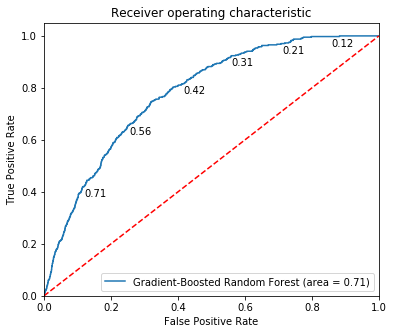

In [190]:
logit_roc_auc = roc_auc_score(y_test_tree, y_pred_gb_tree)
fpr,tpr, thresholds = roc_curve(y_test_tree, random_forest_gb_auc_clf.predict_proba(X_test_tree)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient-Boosted Random Forest (area = %0.2f)' % logit_roc_auc)
for x, y, txt in zip(fpr[::500], tpr[::500], thresholds[::500]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = [6.0,5.0];
#plt.savefig('./week_3/GB_Random_Forest_ROC.jpg')
plt.show()

In [191]:
# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.01,0.03,0.1, 0.3, 1]}]

scores = ['precision_macro', 'recall_macro','roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(penalty='l1',class_weight='balanced',max_iter=100), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train_logreg2.to_numpy(), y_train_logreg2["target"].tolist())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_logreg2, clf.predict(X_test_logreg2)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision_macro



/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-pa

Best parameters set found on development set:

{'C': 0.3}

Grid scores on development set:

0.525 (+/-0.004) for {'C': 0.01}
0.527 (+/-0.004) for {'C': 0.03}
0.527 (+/-0.002) for {'C': 0.1}
0.528 (+/-0.001) for {'C': 0.3}
0.527 (+/-0.002) for {'C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     14143
           1       0.07      0.69      0.13       407

    accuracy                           0.73     14550
   macro avg       0.53      0.71      0.48     14550
weighted avg       0.96      0.73      0.82     14550


# Tuning hyper-parameters for recall_macro



/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-pa

Best parameters set found on development set:

{'C': 0.03}

Grid scores on development set:

0.702 (+/-0.031) for {'C': 0.01}
0.708 (+/-0.027) for {'C': 0.03}
0.705 (+/-0.017) for {'C': 0.1}
0.707 (+/-0.004) for {'C': 0.3}
0.705 (+/-0.011) for {'C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     14143
           1       0.07      0.69      0.12       407

    accuracy                           0.73     14550
   macro avg       0.53      0.71      0.48     14550
weighted avg       0.96      0.73      0.82     14550


# Tuning hyper-parameters for roc_auc



/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-pa

Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.771 (+/-0.018) for {'C': 0.01}
0.777 (+/-0.015) for {'C': 0.03}
0.779 (+/-0.012) for {'C': 0.1}
0.779 (+/-0.010) for {'C': 0.3}
0.778 (+/-0.010) for {'C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     14143
           1       0.07      0.68      0.12       407

    accuracy                           0.73     14550
   macro avg       0.53      0.71      0.48     14550
weighted avg       0.96      0.73      0.82     14550




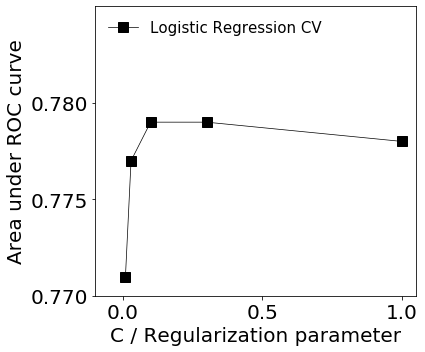

In [204]:
plt.figure()
plt.plot([0.01,0.03,0.1,0.3,1],[0.771,0.777,0.779,0.779,0.778], c='k',lw=0.7,marker="s",ms=10,label='Logistic Regression CV')
plt.xticks([0.0,0.5, 1.0],fontsize=20)
plt.yticks([0.77,0.775,0.78],fontsize=20)
plt.xlim([-0.1, 1.05])
plt.ylim([0.77, 0.785])
plt.xlabel('C / Regularization parameter',fontsize=20)
plt.ylabel('Area under ROC curve',fontsize=20)
#plt.title('Receiver operating characteristic')
#plt.legend(loc="lower right")
plt.legend(frameon=False,loc="upper left",fontsize=15)
plt.tight_layout()
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.savefig('./week_4/Logistic_Regression_CV.jpg')
plt.show()

In [23]:
#C=0.03-1,auc is 0.78
logistic_regressor_cv = LogisticRegression(C=0.03,penalty='l1',class_weight='balanced',max_iter=100)
logistic_regressor_cv.fit(X_train_logreg2.to_numpy(), y_train_logreg2["target"].tolist())
y_pred_logreg = logistic_regressor_cv.predict(X_test_logreg2)

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
joblib.dump(logistic_regressor_cv,"./models/logistic_regressor_scaled_features.mdl")

['./models/logistic_regressor_scaled_features.mdl']

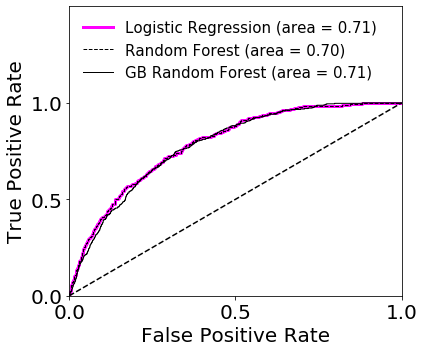

In [207]:
logit_roc_auc = roc_auc_score(y_test_logreg2, y_pred_logreg)
logit_roc_auc2 = roc_auc_score(y_test_tree, y_pred_tree)
logit_roc_auc3 = roc_auc_score(y_test_tree, y_pred_gb_tree)
fpr,tpr, thresholds = roc_curve(y_test_logreg2, logistic_regressor_cv.predict_proba(X_test_logreg2)[:,1])
fpr2,tpr2,thresholds2 = roc_curve(y_test_tree, random_forest_clf.predict_proba(X_test_tree)[:,1])
fpr3,tpr3, thresholds3 = roc_curve(y_test_tree, random_forest_gb_auc_clf.predict_proba(X_test_tree)[:,1])
plt.figure()
plt.plot(fpr, tpr, c='magenta',lw=3.0,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr,tpr,c='black',lw=1.0,ls='--',label='Random Forest (area = %0.2f)' % logit_roc_auc2)
plt.plot(fpr3, tpr3, c='black',lw=1.0,label='GB Random Forest (area = %0.2f)' % logit_roc_auc3)
#for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
#    plt.annotate(np.round(txt,2), (x, y-0.06),fontsize=15)
plt.plot([0, 1], [0, 1],'k--')
plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.yticks([0.0,0.5,1.0],fontsize=20)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.5])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
#plt.title('Receiver operating characteristic')
#plt.legend(loc="lower right")
plt.legend(frameon=False,loc="upper left",fontsize=15)
plt.tight_layout()
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.savefig('./week_4/Logistic_Regression_RF_GBRF_AUCROC.jpg')
plt.show()

In [208]:
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

In [209]:
sampler2 = UnderSampler(sampling_strategy=0.5)
X_tree_balanced2, y_tree_balanced2 = sampler2.fit_sample(X_train_tree.to_numpy(),y_train_tree["target"].tolist())
sampler10 = UnderSampler(sampling_strategy=0.1)
X_tree_balanced10, y_tree_balanced10 = sampler10.fit_sample(X_train_tree.to_numpy(),y_train_tree["target"].tolist())

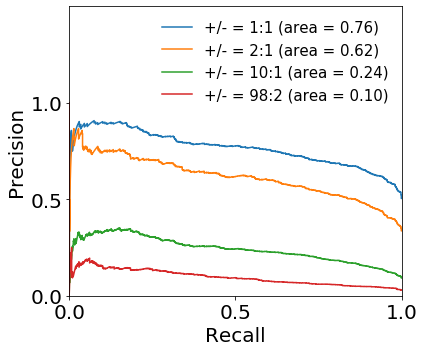

In [211]:
#logit_roc_auc = roc_auc_score(y_test_tree, y_pred_gb_tree)
precision_train,recall_train, thresholds_train = precision_recall_curve(y_tree_balanced, logistic_regressor_cv.predict_proba(X_tree_balanced)[:,1])
precision2,recall2, thresholds2 = precision_recall_curve(y_tree_balanced2, logistic_regressor_cv.predict_proba(X_tree_balanced2)[:,1])
precision10,recall10, thresholds10 = precision_recall_curve(y_tree_balanced10, logistic_regressor_cv.predict_proba(X_tree_balanced10)[:,1])
precision,recall, thresholds = precision_recall_curve(y_test_logreg2, logistic_regressor_cv.predict_proba(X_test_logreg2)[:,1])

plt.figure()
plt.plot(recall_train, precision_train, label='+/- = 1:1 (area = %0.2f)' % metrics.auc(recall_train,precision_train))
plt.plot(recall2, precision2, label='+/- = 2:1 (area = %0.2f)' % metrics.auc(recall2,precision2))
plt.plot(recall10, precision10, label='+/- = 10:1 (area = %0.2f)' % metrics.auc(recall10,precision10))
plt.plot(recall, precision, label='+/- = 98:2 (area = %0.2f)' % metrics.auc(recall,precision))

#plt.plot([0, 1], [0, 1],'r--')
#for x, y, txt in zip(recall[::3000], precision[::3000], thresholds[::3000]):
#    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.5])
plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.yticks([0.0,0.5,1.0],fontsize=20)
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
#plt.title('Precision-Recall Curve')
plt.legend(loc="upper right",fontsize=15,frameon=False)
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout()
plt.savefig('./week_4/Logistic_regression_precision_recall_detection_limit.jpg')
plt.show()

In [212]:
y_test_logreg2.shape

(14550, 1)

In [213]:
random_guess = [0]*14550

In [214]:
import random

In [215]:
for idx,i in enumerate(random_guess):
    x = random.uniform(0,1)
    if x >= 0.98:
        random_guess[idx] = 1

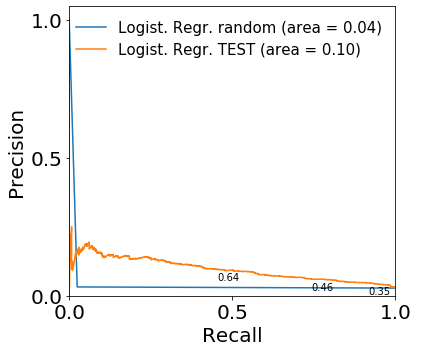

In [216]:
#logit_roc_auc = roc_auc_score(y_test_tree, y_pred_gb_tree)
precision_random,recall_random, thresholds_random = precision_recall_curve(y_test_logreg2, random_guess)
precision,recall, thresholds = precision_recall_curve(y_test_logreg2, logistic_regressor_cv.predict_proba(X_test_logreg2)[:,1])
precision_train,recall_train, thresholds_train = precision_recall_curve(y_tree_balanced, logistic_regressor_cv.predict_proba(X_tree_balanced)[:,1])
plt.figure()
plt.plot(recall_random, precision_random, label='Logist. Regr. random (area = %0.2f)' % metrics.auc(recall_random,precision_random))
plt.plot(recall, precision, label='Logist. Regr. TEST (area = %0.2f)' % metrics.auc(recall,precision))
#plt.plot(recall_train, precision_train, label='Logistic Regression TRAIN (area = %0.2f)' % metrics.auc(recall_train,precision_train))
#plt.plot([0, 1], [0, 1],'r--')
for x, y, txt in zip(recall[::3000], precision[::3000], thresholds[::3000]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.xticks([0,0.5,1.0],fontsize=20)
plt.yticks([0,0.5,1.0],fontsize=20)
#plt.title('Precision-Recall Curve')
plt.legend(loc="upper right",fontsize=15,frameon=False)
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout()
#plt.savefig('./week_4/Logistic_regression_precision_recall_vs_random.jpg')
plt.show()

In [217]:
random_guess_test_set = random_guess

In [231]:
random_guess_50 = [0]*1842

In [232]:
for idx,i in enumerate(random_guess_50):
    x = random.uniform(0,1)
    if x >= 0.50:
        random_guess_50[idx] = 1

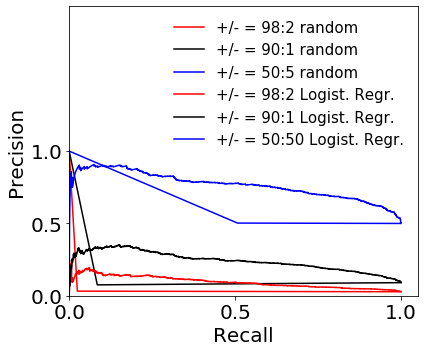

In [244]:
#logit_roc_auc = roc_auc_score(y_test_tree, y_pred_gb_tree)
precision_train,recall_train, thresholds_train = precision_recall_curve(y_tree_balanced, logistic_regressor_cv.predict_proba(X_tree_balanced)[:,1])
precision_random_50,recall_random_50, thresholds_random_50 = precision_recall_curve(y_tree_balanced, random_guess_50)
precision_random,recall_random, thresholds_random = precision_recall_curve(y_test_logreg2, random_guess)
precision,recall, thresholds = precision_recall_curve(y_test_logreg2, logistic_regressor_cv.predict_proba(X_test_logreg2)[:,1])
precision_random_10,recall_random_10, thresholds_random_10 = precision_recall_curve(y_tree_balanced10, random_guess_10)
precision10,recall10, thresholds10 = precision_recall_curve(y_tree_balanced10, logistic_regressor_cv.predict_proba(X_tree_balanced10)[:,1])
plt.figure()
plt.plot(recall_random, precision_random, c='r', label='+/- = 98:2 random')
plt.plot(recall_random_10, precision_random_10, c='k', label='+/- = 90:1 random')
plt.plot(recall_random_50, precision_random_50, c='b',label='+/- = 50:5 random')
plt.plot(recall, precision, c='r',label='+/- = 98:2 Logist. Regr.')
plt.plot(recall10, precision10,c='k', label='+/- = 90:1 Logist. Regr.')
plt.plot(recall_train, precision_train,c='b', label='+/- = 50:50 Logist. Regr.')
#plt.plot([0, 1], [0, 1],'r--')
#for x, y, txt in zip(recall[::3000], precision[::3000], thresholds[::3000]):
 #   plt.annotate(np.round(txt,2), (x, y-0.04))
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 2.0])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.xticks([0,0.5,1.0],fontsize=20)
plt.yticks([0,0.5,1.0],fontsize=20)
#plt.title('Precision-Recall Curve')
plt.legend(fontsize=15,frameon=False)
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout()
plt.savefig('./week_4/Logistic_regression_precision_recall_vs_random.jpg')
plt.show()

In [230]:
y_tree_balanced.shape

(1842,)

### What are the important features in logistic regression?

In [245]:
features_names = list(X_train_tree.columns)
logistic_regression_coeffs = logistic_regressor_cv.coef_

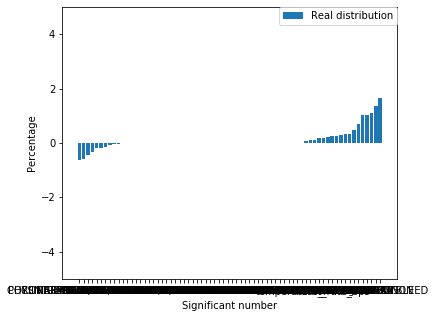

In [247]:
import operator
x = dict(zip(features_names,logistic_regression_coeffs[0]))
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
features = [item[0] for item in sorted_x]
coeffs = [item[1] for item in sorted_x]


plt.bar(features, coeffs , label="Real distribution")

plt.ylim(-5,5)
plt.ylabel ('Percentage')
plt.xlabel ('Significant number')
#plt.xticks(list(keys))
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()

In [248]:
sorted_x

[('CORONARY ARTERY DISEASE', -0.623852812031532),
 ('PHYS REFERRAL/NORMAL DELI', -0.5717691930860272),
 ('ELECTIVE', -0.43268536322907286),
 ('OTHER', -0.31959157643880604),
 ('CLINIC REFERRAL/PREMATURE', -0.1828789215109791),
 ('ASIAN', -0.17298415780768628),
 ('INTRACRANIAL HEMORRHAGE', -0.15606210950816116),
 ('HISPANIC', -0.08622395384494073),
 ('URGENT', -0.049807052554758015),
 ('EMERGENCY ROOM ADMIT', -0.024488488379435406),
 ('EMERGENCY', 0.0),
 ('** INFO NOT AVAILABLE **', 0.0),
 ('HMO REFERRAL/SICK', 0.0),
 ('TRANSFER FROM OTHER HEALT', 0.0),
 ('TRANSFER FROM SKILLED NUR', 0.0),
 ('TRSF WITHIN THIS FACILITY', 0.0),
 ('BLACK', 0.0),
 ('CONGESTIVE HEART FAILURE', 0.0),
 ('ALTERED MENTAL STATUS', 0.0),
 ('UPPER GI BLEED', 0.0),
 ('GASTROINTESTINAL BLEED', 0.0),
 ('LOWER GI BLEED', 0.0),
 ('RESPIRATORY FAILURE', 0.0),
 ('CHEST PAIN', 0.0),
 ('S/P FALL', 0.0),
 ('GI BLEED', 0.0),
 ('TRANSIENT ISCHEMIC ATTACK', 0.0),
 ('UROSEPSIS', 0.0),
 ('DEHYDRATION', 0.0),
 ('WEAKNESS', 0.0),
 

In [249]:
log_reg_feature_importance = pd.DataFrame({'feature':['Colitis','Sepsis','Fever','Diarrhea','Hypotension','Length of Stay','Age'],'weight':[1.63,1.4,1.1,1.03,1.03,0.7,0.49]})


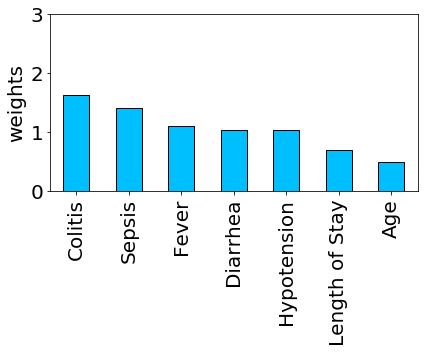

In [250]:
log_reg_feature_importance.plot(kind='bar',legend=None,x='feature',y='weight',facecolor='deepskyblue',edgecolor='black');
plt.xticks(fontsize=20)
plt.xlabel('');
plt.yticks([0.0,1.0,2.0,3.0],fontsize=20);
plt.ylabel('weights',fontsize=20);
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout();
plt.savefig("./week_4/feature_importance_log_reg.jpg")

## PROBABILITY DISTRIBUTION OF POSTIVE AND NEGATIVE CASES

In [25]:
logistic_regressor = joblib.load("./models/logistic_regressor_scaled_features.mdl")

In [27]:
cdiff_pos_preprocess = ADMISSIONS_CDiff_preprocess.loc[ADMISSIONS_CDiff_preprocess['target'] == 1]
cdiff_neg_preprocess = ADMISSIONS_CDiff_preprocess.loc[ADMISSIONS_CDiff_preprocess['target'] == 0]
cdiff_pos_preprocess_inputs = cdiff_pos_preprocess.loc[:,cdiff_pos_preprocess.columns != 'target']
cdiff_neg_preprocess_inputs = cdiff_neg_preprocess.loc[:,cdiff_neg_preprocess.columns != 'target']

In [28]:
cdiff_pos_probs = logistic_regressor.predict_proba(cdiff_pos_preprocess_inputs.to_numpy())[:,1]
cdiff_neg_probs = logistic_regressor.predict_proba(cdiff_neg_preprocess_inputs.to_numpy())[:,1]

In [29]:
cdiff_pos_probs = pd.DataFrame({'C. diff. positive':cdiff_pos_probs})
cdiff_neg_probs = pd.DataFrame({'C. diff. negative':cdiff_neg_probs})

In [32]:
cdiff_pos_probs['C. diff. positive'].to_csv("./data/p_dists/cdiff_pos_prob_scaled_features.csv",index=False)
cdiff_neg_probs['C. diff. negative'].to_csv("./data/p_dists/cdiff_neg_prob_scaled_features.csv",index=False)

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


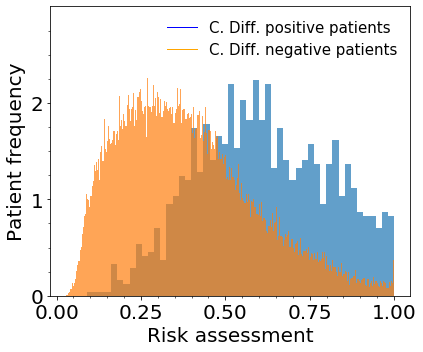

In [31]:
ax=plt.gca()
ax.set_xticks(np.arange(0.0,1.0,0.05),minor=True)
ax.set_yticks(np.arange(0.0,3.0,0.25),minor=True)
cdiff_pos_probs.hist(bins=50,density=True,grid=False,ax=ax,alpha=0.7);
cdiff_neg_probs.hist(bins=300,density=True,grid=False,ax=ax,alpha=0.7);
plt.title(label="");
cdiff_pos = mlines.Line2D([], [], c='b', lw=1.0, label = 'C. Diff. positive patients');
cdiff_neg = mlines.Line2D([], [], c='orange', lw=1.0, label='C. Diff. negative patients');
plt.legend(handles=[cdiff_pos,cdiff_neg],frameon=False,fontsize=15);
plt.xlabel("Risk assessment",fontsize=20);
plt.ylabel("Patient frequency",fontsize=20);
plt.xticks([0.0,0.25,0.5,0.75,1.0],fontsize=20);
plt.yticks([0.0,1.0,2.0],fontsize=20);
plt.ylim([0,3.0]);
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout();
plt.savefig("./week_4/cdiff_populations.jpg")

In [33]:
features_names = list(X_train_tree.columns)
logistic_regression_coeffs = logistic_regressor.coef_

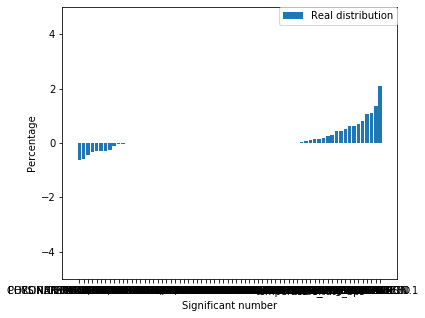

In [34]:
import operator
x = dict(zip(features_names,logistic_regression_coeffs[0]))
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
features = [item[0] for item in sorted_x]
coeffs = [item[1] for item in sorted_x]


plt.bar(features, coeffs , label="Real distribution")

plt.ylim(-5,5)
plt.ylabel ('Percentage')
plt.xlabel ('Significant number')
#plt.xticks(list(keys))
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()

In [35]:
sorted_x

[('CORONARY ARTERY DISEASE', -0.6397193868251428),
 ('PHYS REFERRAL/NORMAL DELI', -0.5764023931873339),
 ('ELECTIVE', -0.4526564653950997),
 ('CHEST PAIN', -0.31736456877874397),
 ('CLINIC REFERRAL/PREMATURE', -0.3080362911492345),
 ('URGENT', -0.2888966575202032),
 ('OTHER', -0.28309056595282234),
 ('HISPANIC', -0.2451015036853609),
 ('ASIAN', -0.10308116542936734),
 ('EMERGENCY ROOM ADMIT', -0.05249467753371697),
 ('INTRACRANIAL HEMORRHAGE', -0.02602530251593576),
 ('EMERGENCY', 0.0),
 ('** INFO NOT AVAILABLE **', 0.0),
 ('HMO REFERRAL/SICK', 0.0),
 ('TRANSFER FROM HOSP/EXTRAM', 0.0),
 ('TRANSFER FROM SKILLED NUR', 0.0),
 ('TRSF WITHIN THIS FACILITY', 0.0),
 ('BLACK', 0.0),
 ('CONGESTIVE HEART FAILURE', 0.0),
 ('UPPER GI BLEED', 0.0),
 ('GASTROINTESTINAL BLEED', 0.0),
 ('LOWER GI BLEED', 0.0),
 ('S/P FALL', 0.0),
 ('DYSPNEA', 0.0),
 ('GI BLEED', 0.0),
 ('TRANSIENT ISCHEMIC ATTACK', 0.0),
 ('UROSEPSIS', 0.0),
 ('RESPIRATORY DISTRESS', 0.0),
 ('WEAKNESS', 0.0),
 ('HIP FRACTURE', 0.0),
